# Pupil Dilation Measurement using Near Infrared
### Algorithm
 1. Load Color and Infrared Images
 2. Threshold Infrared Image to help locate eyes
 3. Get infrared co-ordinates for an eye
 4. Convert co-ordinates to lie on Color Plane
 5. Convert image to YIQ for skin detection
 6. Use this to verify that co-ordinates point to an eye
 7. Create a sub-image containing only the eye
 8. Detect Pupil and Iris using Circle Hough
 9. Deduce ratio and dilation from measurements
 10.Display Stats, Graphs and Images

In [1]:
!pip3 install opencv-contrib-python numpy

### New Image

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Load the original image
original_image = cv2.imread("/content/color_image.jpeg")

# Check if the image is loaded successfully
if original_image is None:
    print("Error: Unable to load the image.")
else:
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    # Apply a pseudocolor map to the grayscale image
    infrared_image = cv2.applyColorMap(gray_image, cv2.COLORMAP_HOT)

    # Save the infrared image
    cv2.imwrite("/content/infrared_image.jpg", infrared_image)

    # Display the original and infrared images
    cv2_imshow(original_image)
    cv2_imshow(infrared_image)


In [60]:
infrared_image_path = '/content/Infrared Nov 22 2019.jpeg'
color_image_path = '/content/Color Nov .jpeg'

infrared_image_input = cv2.imread(infrared_image_path)
color_image_input = cv2.imread(color_image_path)

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from fractions import Fraction

### Measurement

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from fractions import Fraction

In [5]:
def get_infrared_eye_coords(binary_image):
    # Derive coords from mask
    y_index, x_index = np.where(binary_image != 0)
    eye_x = x_index[0]
    eye_y = y_index[0]
    return eye_x, eye_y

def threshold_infrared_for_coords(image):
    # Threshold for eyes
    mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask[mask < 235] = 0
    mask[mask != 0] = 255
    eye_x, eye_y = get_infrared_eye_coords(mask)
    return eye_x, eye_y, mask

# Convert Infrared Coordinates to lie on Color Plane
def infrared_to_color(x, y):
    if y < 175 or y > 472 or x > 470 or x < 20 :
        raise IndexError("Coordinates do not lie on Color Image")

    x -= 20
    x = int(x/.275)
    x += 210

    y -= 175
    y = int(y/.275)

    return x, y

# This detects and measures pupil
def detect_and_measure_pupil(infrared_image_input, color_image_input):
    if infrared_image_input is None or color_image_input is None :
        print("2 non-empty images required")
        return False
    infrared_image = infrared_image_input.copy()
    color_image = color_image_input.copy()

    # Threshold for eyes
    try:
        infrared_eye_x, infrared_eye_y, image_mask = threshold_infrared_for_coords(infrared_image)
    except:
        print("Unable to create Mask from infrared image")
        return False

    # Convert Infrared Coordinates to lie on Color Plane
    try:
        color_eye_x, color_eye_y = infrared_to_color(infrared_eye_x, infrared_eye_y)
    except IndexError:
            print("Coordinates do not lie on Color Image")
            return False

    return color_eye_x, color_eye_y, infrared_eye_x, infrared_eye_y, image_mask




def get_eye_bounding_box(image, eye_x, eye_y, offset=80):
    validation = image.copy()
    return validation[eye_y - offset : eye_y + offset, eye_x - offset : eye_x + offset], eye_x - offset, eye_y - offset


def yiq_conversion(rgb_vector):
    height, width, _ = np.shape(rgb_vector)

    rgb_vector = np.asarray(rgb_vector)
    yiq_matrix = np.array([[0.299  ,  0.587  , 0.114   ],
                           [0.5959 , -0.2746 , -0.3213 ],
                           [0.2115 , -0.5227 , 0.3112  ]])
    b = rgb_vector[:, :, 0]
    g = rgb_vector[:, :, 1]
    r = rgb_vector[:, :, 2]

    for x in range(0, width):
        for y in range(0,height):
            rgb_vector[x][y] = yiq_matrix.dot([b[x,y],g[x,y],r[x,y]])
    return rgb_vector


def median_color_of_image(image):
   mask = image.copy()
   median_array = np.asarray(mask)
   sort = np.sort(median_array)
   medians = np.median(sort, axis=0)
   return medians[len(medians) // 2]


def draw_median_circle(image, eye_x, eye_y, median):
    median_image = image.copy()
    cv2.circle(median_image, (eye_x, eye_y), 40, (int(median[0]), int(median[2]), int(median[1])), -1)
    return median_image


def validate_region(image):
    mean, std = cv2.meanStdDev(image)

    if mean[1] > 200 and mean[0] < 100 and mean[2] < 50:
        message = "The surrounding region is dominated by skin, therefore it has a good chance of being the eye"
        return True, mean, std, message
    else:
        message = "Region is not dominant by skin therefore poor chance of being eye region"
        return False, mean, std, message

def validator(image, eye_x, eye_y):
    original = image.copy()

    bounded_image, cropped_x, cropped_y = get_eye_bounding_box(original, eye_x, eye_y)

    yiq_image = yiq_conversion(bounded_image)

    median_color = median_color_of_image(yiq_image)

    bounded = draw_median_circle(yiq_image, eye_x - cropped_x, eye_y - cropped_y, median_color)

    validation, mean, std, message = validate_region(bounded)

    return validation, mean, std, message,  yiq_image


# Crops down to a 250x250 region centred on the eye given by Bryan's code
def crop_to_eye(image, cian_x, cian_y):
	return image[cian_y-125:cian_y+125, cian_x-125:cian_x+125]

# Convert an image to grayscale and apply a blur for the Circle Hough Transform
def blur_grayscale(image, blur):
  blurred_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return cv2.medianBlur(blurred_image, blur)

# Detect the iris or pupil
def draw_detection(image, detection):
  try:
    detection = np.uint16(np.around(detection))
    x, y, r = detection[0, 0]
    cv2.circle(image, (x, y), 2, (0, 0, 255), -1)
    cv2.circle(image, (x, y), r, (255, 0, 0), 1)
  except:
	  print("No circles were found")

  return image, x, y, r

# Calculate the ratio, simplify it and then return the numerator and denominator
def get_ratio(pr, ir):
  # Radius in millimeters
  iris_mm = 6.5

  ratio = Fraction(pr, ir)
  pupil_px = ratio.numerator
  iris_px = ratio.denominator

  # Using the ratio of millimeters : pixels for the iris,
  # we can use this factor to find the size in mm of the pupil
  # since we know its size in pixels
  px_to_mm_factor = iris_mm / iris_px
  pupil_mm = pr * px_to_mm_factor

  return pupil_px, iris_px, pupil_mm, iris_mm

# This detects the iris and pupil and returns the final image
# It takes in the original color image and the x and y co-ordinates returned from Bryan's and Valentin's code
def detect_iris_and_pupil(image, cian_x, cian_y):
  if image is None:
    print("Image is empty")
    return

  # Crop down to the eye region
  cropped_image = crop_to_eye(image, cian_x, cian_y)

  # Use one image for detecting the iris, pupil
  iris_detection = cropped_image.copy()
  pupil_detection = cropped_image.copy()
  final_detection = cropped_image.copy()

  # Find the iris
  gray_cropped = blur_grayscale(iris_detection, 17)
  iris = cv2.HoughCircles(gray_cropped, cv2.HOUGH_GRADIENT, 1, iris_detection.shape[0], param1=50, param2=20, minRadius=0, maxRadius=48)
  iris_detection, ix, iy, ir = draw_detection(iris_detection, iris)

  # Find the pupil
  gray_cropped = blur_grayscale(pupil_detection, 19)
  pupil = cv2.HoughCircles(gray_cropped, cv2.HOUGH_GRADIENT, 1, pupil_detection.shape[0], param1=50, param2=15, minRadius=0, maxRadius=ir-4)
  pupil_detection, px, py, pr = draw_detection(pupil_detection, pupil)

  # draw the final detection
  cv2.circle(final_detection, (ix, iy), 2, (0, 0, 255), 2)
  cv2.circle(final_detection, (ix, iy), ir, (255, 0, 0), 2)
  cv2.circle(final_detection, (px, py), pr, (255, 0, 0), 2)

  # Get ratio in pixels and millimeters
  pupil_px, iris_px, pupil_mm, iris_mm = get_ratio(pr, ir)

  return final_detection, pupil_px, iris_px, pupil_mm, iris_mm, gray_cropped

# Plot code here
def display_results(infrared, image_mask, yiq_image, mean, cropped_normal_eye, grey_cropped, final_detection, eye_x, eye_y, message, pupil_px, iris_px, pupil_mm, iris_mm):
    # ploting the image
    plt.figure(figsize=(30,20))
    grid = plt.GridSpec(3, 3)
    plt.title("Step by step process")
    plt.subplot(grid[0,0])
    plt.imshow(cv2.cvtColor(infrared , cv2.COLOR_BGR2RGB))
    plt.xlabel('Infrared image')


    plt.subplot(grid[0,1])
    plt.imshow(image_mask)
    plt.xlabel('mask of the infrared image')

    plt.subplot(grid[0,2])
    plt.imshow(cv2.cvtColor(yiq_image , cv2.COLOR_BGR2RGB))
    plt.xlabel('YIQ of the cropped section of the eye')

    # this is for the bar chart of the mean
    names = ["Blue scale" , "Green scale" , "Red scale"]
    values = np.ravel(mean)
    plt.subplot(grid[1,0])
    plt.bar(names, values, color=["blue" , "green" , "red"])
    plt.xlabel('Colours')
    plt.ylabel('Colour scale')

    plt.subplot(grid[1,1])
    plt.imshow(cropped_normal_eye)
    plt.xlabel('Cropped normal eye')

    plt.subplot(grid[1,2])
    plt.imshow(cv2.cvtColor(grey_cropped , cv2.COLOR_GRAY2RGB))
    plt.xlabel('Grey eye')


    plt.subplot(grid[2,0])
    plt.imshow(cv2.cvtColor(final_detection , cv2.COLOR_BGR2RGB))
    plt.xlabel('Circle Hough')

    plt.subplot(grid[2, 1:3])
    plt.axis("off")
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0, 0.5, f'Eye co-ordinate: X{eye_x} , Y{eye_y}\n{message}\nRatio of dilation in pixels is {pupil_px}px : {iris_px}px\nRatio of dilation in mm is {pupil_mm}mm : {iris_mm}mm', style='italic',
            bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 20},  fontsize=10)
    plt.show()

def measure_dilation(infrared_path="/content/Infrared.jpeg", color_path="/content/Color.jpeg"):
    infrared = cv2.imread(infrared_path, 1)
    color = cv2.imread(color_path, 1)

    eye_x, eye_y, infrared_eye_x, infrared_eye_y, image_mask = detect_and_measure_pupil(infrared, color)

    validation, mean, std, message, yiq_image = validator(color, eye_x, eye_y)
    if validation is False:
        print("Doesn't pass validation")
        return False

    cropped_normal_eye = infrared[int(infrared_eye_y*.9):int(infrared_eye_y*1.1), int(infrared_eye_x*.9):int(infrared_eye_x*1.1)]

    final_detection, pupil_px, iris_px, pupil_mm, iris_mm, grey_cropped = detect_iris_and_pupil(color, eye_x, eye_y)
    display_results(infrared, image_mask, yiq_image, mean, cropped_normal_eye, grey_cropped, final_detection, eye_x, eye_y, message, pupil_px, iris_px, pupil_mm, iris_mm)

<ipython-input-5-6374f90e59d4>:198: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(grid[0,0])


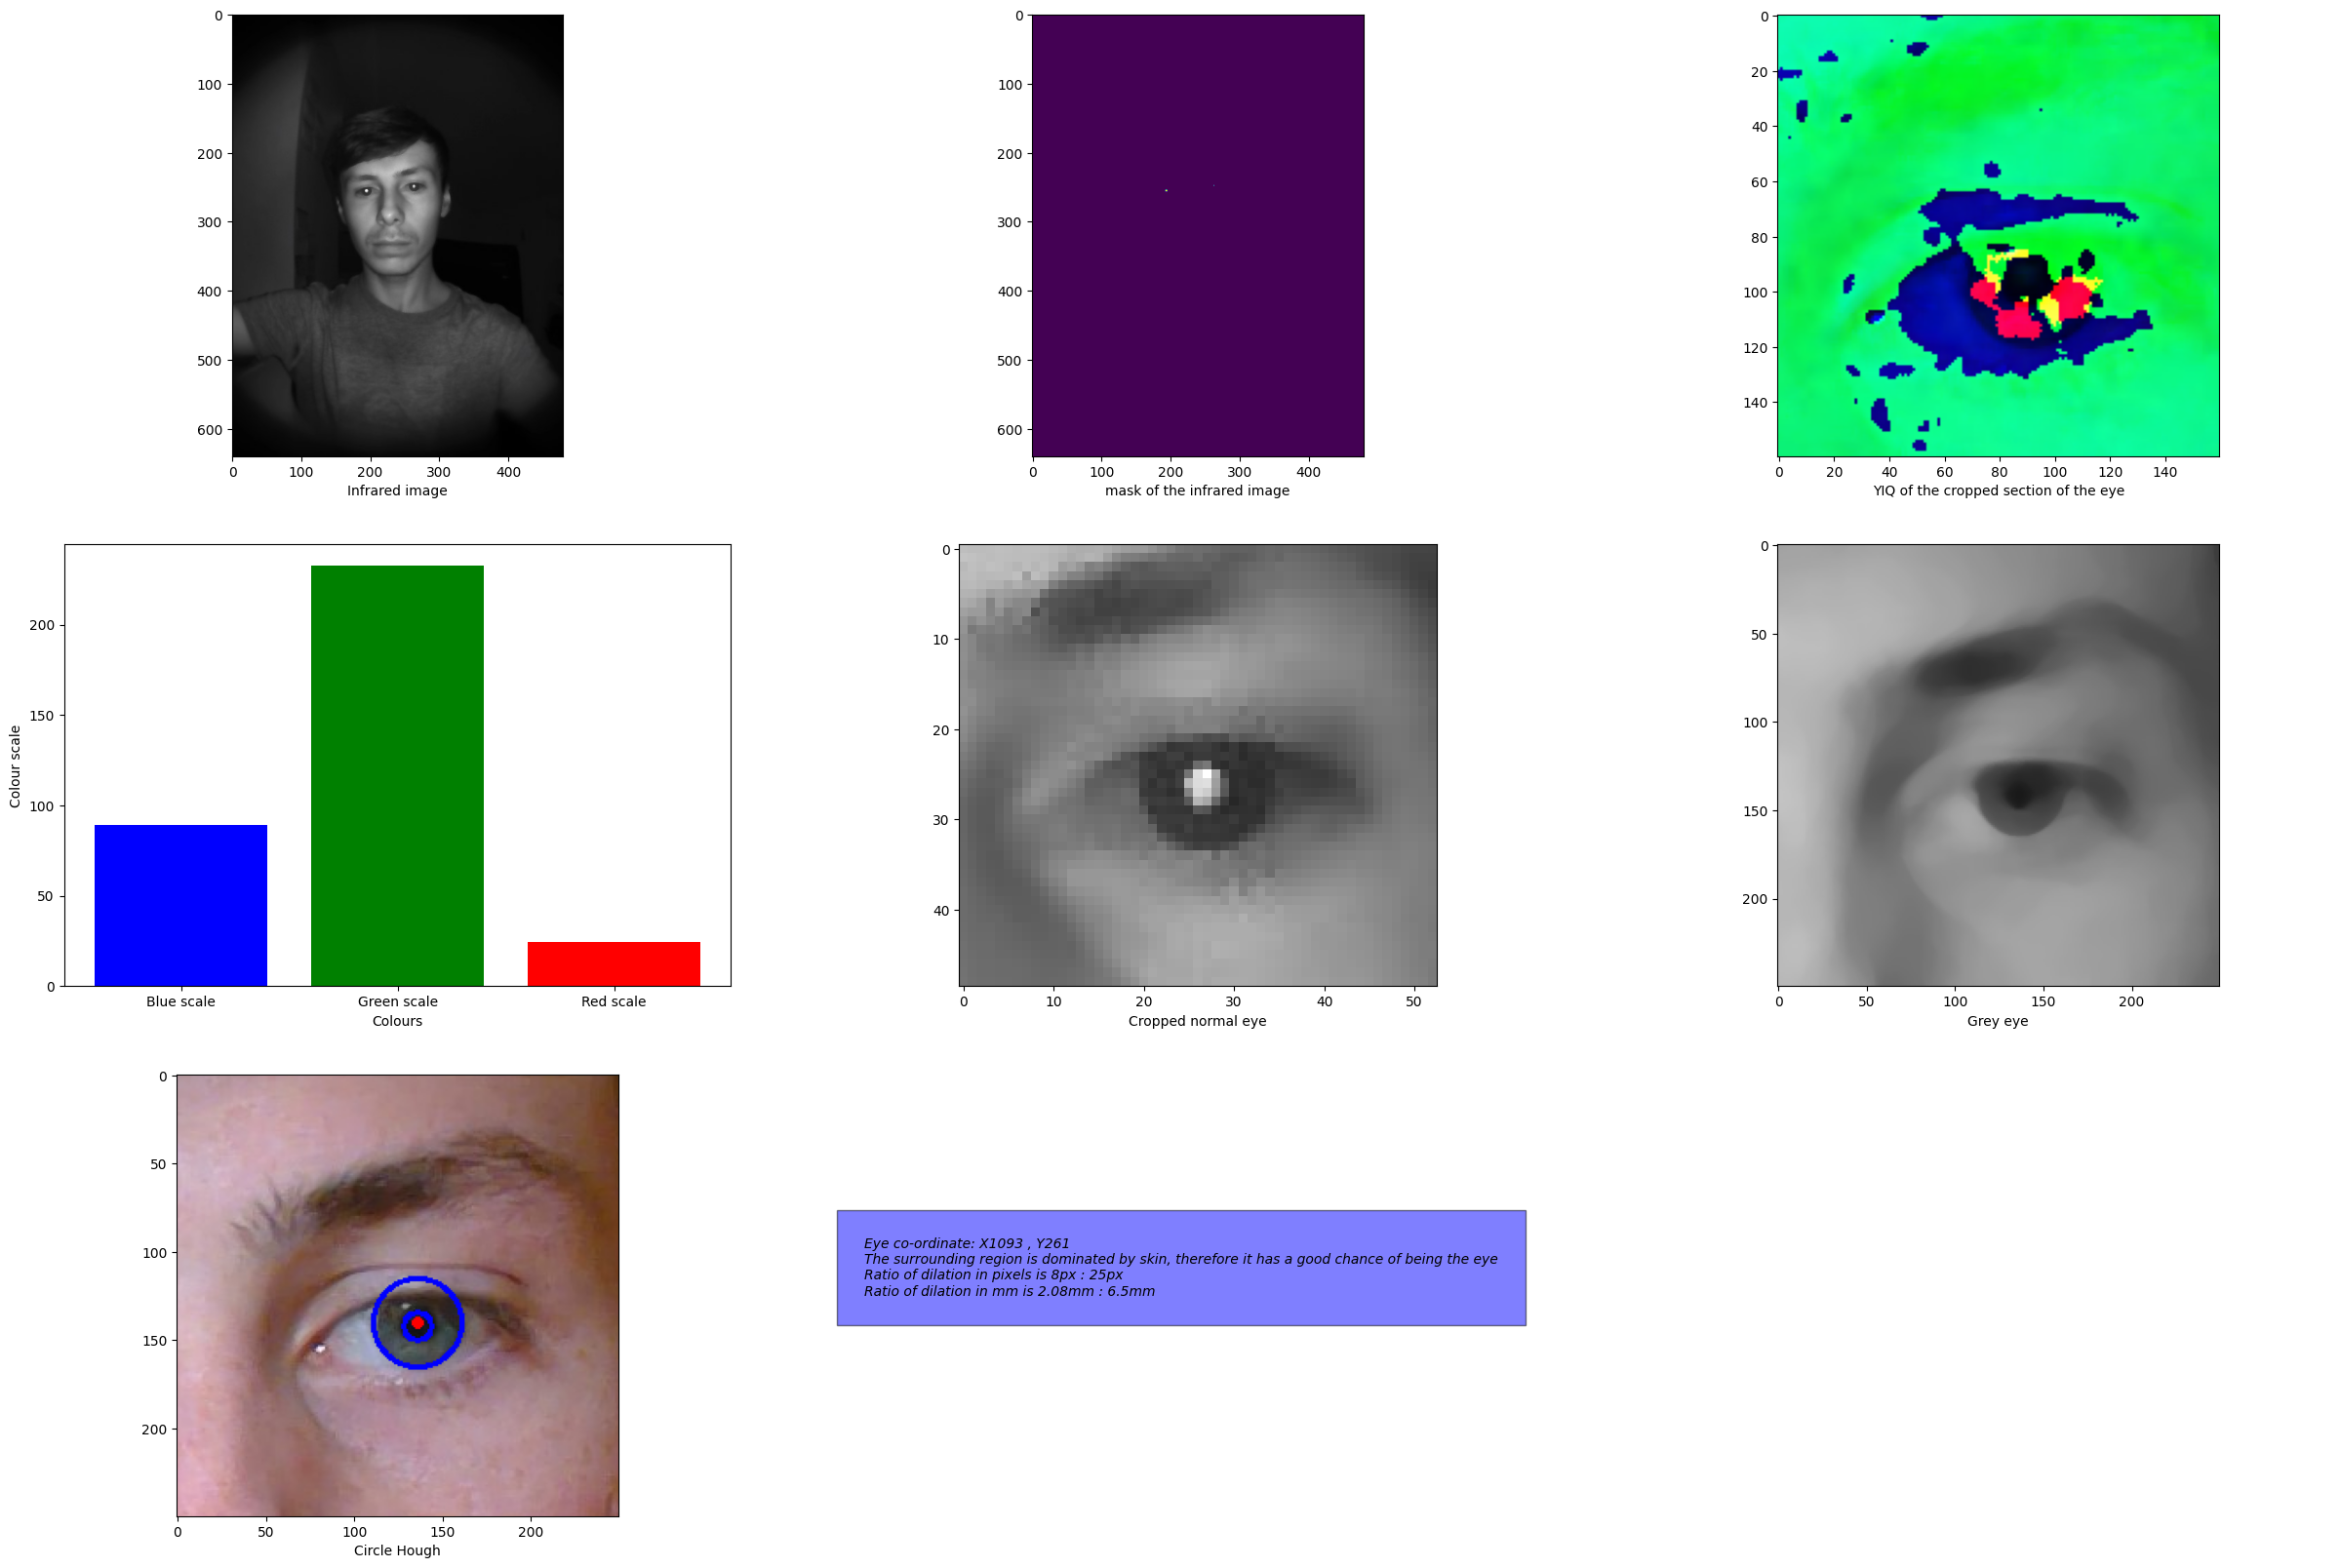

In [33]:
measure_dilation()